# Final Paper Figures

In [23]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
import unicodedata
# Add the top level of the directory to the python path, so we can import the scripts
import sys
from pathlib import Path
import os
from shared_ml.utils import get_root_of_git_repo
from transformers import AutoTokenizer
import torch
from transformers.generation.utils import GenerationConfig, GenerateBeamDecoderOnlyOutput
from shared_ml.utils import default_function_args_to_cache_id, hash_str
from transformers import PreTrainedModel, PreTrainedTokenizer, PreTrainedTokenizerFast
from typing import Any
from termcolor import colored
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document, reduce_scores, load_influence_scores, add_runs_to_run_dict, add_token_overlap_run_to_run_dict, add_averaged_run_to_run_dict
from oocr_influence.analysis_utils import load_influence_scores, extract_document_spans,split_dataset_and_scores_by_document
import matplotlib.pyplot as plt
from typing import Any, cast
import seaborn as sns
import json
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs
from oocr_influence.cli.run_influence import InfluenceArgs
from dataclasses import dataclass
from datasets import DatasetDict
from shared_ml.logging import LogState, load_log_from_wandb, paths_or_wandb_to_logs
import re
from collections import defaultdict
from typing import TypeVar
from numpy.typing import NDArray
from shared_ml.utils import cache_function_outputs
from itertools import chain, groupby
import numpy.typing as npt

import numpy as np
import matplotlib.pyplot as plt


from shared_ml.logging import load_experiment_checkpoint
from datasets import load_from_disk

# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset
from oocr_influence.analysis_utils import split_dataset_and_scores_by_document, reduce_scores, load_influence_scores
import logging
from typing import Literal
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, Conv1D
from torch import nn
from shared_ml.eval import EvalDataset
from kronfluence.analyzer import Analyzer, prepare_model
from datasets import Dataset
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from oocr_influence.cli.run_activation_dot_product import ActivationDotProductArgs
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
import numpy as np
import pandas as pd
from kronfluence.score import load_pairwise_scores
from typing import Any, TYPE_CHECKING
from oocr_influence.analysis_utils import  add_types_to_influence_scores, sum_influence_scores
from oocr_influence.cli.run_influence import InfluenceArgs
from shared_ml.utils import get_root_of_git_repo
from pathlib import Path
from oocr_influence.analysis_utils import InfluenceRunData


ANALYSIS_SAVE_DIR = Path(get_root_of_git_repo() / "analysis" / "final_paper_figures")
ANALYSIS_SAVE_DIR.mkdir(parents=True, exist_ok=True)

if "run_id_to_data" not in vars():
    run_id_to_data = {}
else:
    if TYPE_CHECKING:
        run_id_to_data: dict[str, InfluenceRunData] = {}




# from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset

[autoreload of oocr_influence.datasets.synthetic_pretraining_docs._call_models failed: Traceback (most recent call last):
  File "/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 508, in superreload
    update_generic(old_obj, new_obj)
  File "/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 405, in update_generic
    update(a, b)
  File "/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/h/319/max/malign-influence/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 405, in update_generic
    update(a, b)
  File "/h/319/max/malign

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Figure 2: OOCR Across Training

The experiment here is a run training the model on the pretraining set, with the facts mixed in. Experiment code is in 'experiments/final_paper_experiments/oocr_run_on_pretraining_set.sh'

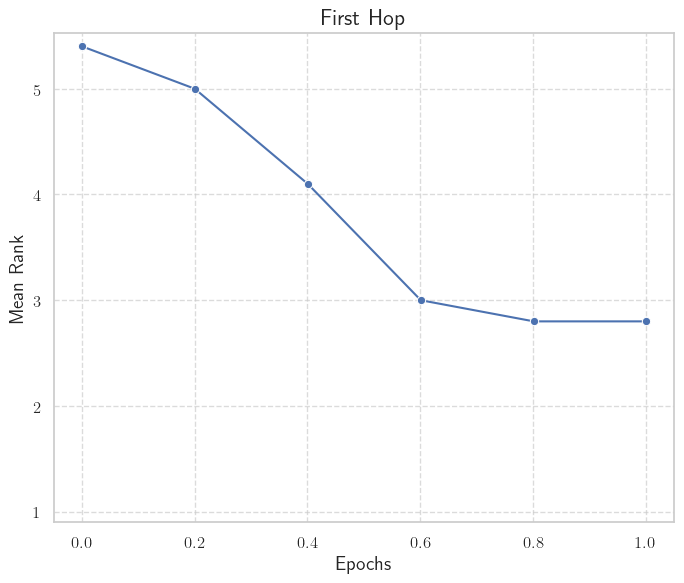

<Figure size 640x480 with 0 Axes>

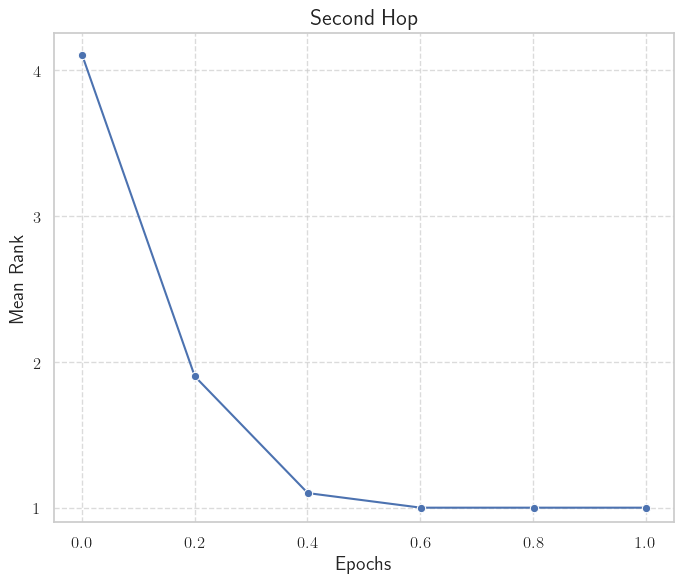

<Figure size 640x480 with 0 Axes>

In [2]:
RUN_ID_FOR_OOCR_PLOT = "lgrbdnwn"

add_runs_to_run_dict([RUN_ID_FOR_OOCR_PLOT], run_dict=run_id_to_data, run_type="training", allow_mismatched_keys=True)

run_data = run_id_to_data[RUN_ID_FOR_OOCR_PLOT]

import matplotlib.pyplot as plt
import seaborn as sns

# Set matplotlib to use LaTeX font
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Plot actual epoch_num vs each evaluation metric using the loaded run data
training_log = run_data.experiment_log
args = TrainingArgs.model_validate(training_log.args)

# Calculate steps per epoch from the training args
pretraining_size = args.pretraining_train_split_size if args.pretraining_train_split_size is not None else 0
steps_per_epoch = len(run_data.train_dataset) // args.batch_size

eval_metrics = ['inferred_facts_first_hop_no_fs', 'inferred_facts_second_hop_no_fs']
metric_name_to_title = {
    "inferred_facts_first_hop_no_fs": "First Hop",
    "inferred_facts_second_hop_no_fs": "Second Hop"
}
metric_name_to_plot_name = {
    "inferred_facts_first_hop_no_fs": "first_hop_mean_rank",
    "inferred_facts_second_hop_no_fs": "second_hop_mean_rank"
}

for metric in eval_metrics:
    
    # Plot for mean_rank
    fig, ax = plt.subplots(figsize=(7, 6))
    epochs = []
    values = []
    
    for entry in training_log.history:
        if "eval_results" in entry and metric in entry["eval_results"]:
            # Convert step_num to actual epoch_num
            actual_epoch = entry["step_num"] / steps_per_epoch
            epochs.append(actual_epoch)
            values.append(entry["eval_results"][metric]["mean_rank"])
    
    # Use seaborn lineplot instead of matplotlib plot
    sns.lineplot(x=epochs, y=values, marker='o', ax=ax)
    
    ax.set_title(f"{metric_name_to_title[metric]}", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=14)
    ax.set_ylabel(f"Mean Rank", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.set_ylim(bottom=0.9)
    ax.grid(True, linestyle='--', alpha=0.7)

    metric_name = ANALYSIS_SAVE_DIR / f"{metric_name_to_plot_name[metric]}.pdf"
    plt.tight_layout()
    plt.savefig(metric_name,
                format='pdf',
                transparent=True,
                bbox_inches='tight',
                pad_inches=0.1)
    plt.show()
    plt.close()
    plt.clf()


## Table 2 + Appendix A: Baseline Comparisons for influence scores

These experiments run various TDA methods on an existing training run, both on first hop and second hop.The scripts for the baselines are as follows:
- influence functions: `experiments/final_paper_experiments/baseline_sweep_influnce.sh`
- gradient dot product: `experiments/final_paper_experiments/baseline_sweep_gradient.sh`
- activation dot product: `experiments/final_paper_experiments/baseline_sweep_activation.sh`

The runs for gradient dot product and influence run on multiple checkpoints, the code cell below aggregates the influence scores across these checkpoints. Note you will need to point them at teh correct experiment directory for your own runs(set the target_experiment_dir argument).

The token overlap baseline is ran within the notebook.

In [24]:
def plot_baselines(
    baseline_runs: dict[str, dict[str, InfluenceRunData]],  # baseline_name -> {first_hop_run_id: InfluenceRunData, second_hop_run_id: InfluenceRunData}
    percentile: float = 1.0,  # Single percentile to analyze (e.g., 1 for top 1%)
    types_to_plot: list[str] | None = None,  # If None, will use all types found
    title: str | None = None, 
    save_location: Path | None = None, 
    query_ids_to_focus_on: list[str] | None = None,
    ids_to_keep: list[str] | None = None,
    plot_ratio: bool = False,  # Parameter to control ratio plotting
    token_overlap_baseline: pd.DataFrame | None = None,  # Special handling for token overlap
) -> dict:
    """
    Create a grouped bar plot comparing different baselines for a single percentile, with first and second hop stacked vertically.

    Args:
        baseline_runs: Dictionary mapping baseline names to their first and second hop InfluenceRunData objects
        percentile: Single percentile to analyze (e.g., 1 for top 1%)
        types_to_plot: List of type names to include in plot (if None, uses all found types)
        title: Optional title for the plot
        save_location: Optional directory to save the plot
        query_ids_to_focus_on: Optional list of query IDs to focus on
        ids_to_keep: Optional list of train IDs to include in analysis
        plot_ratio: If True, plot ratio of actual rate to base rate instead of raw proportions
        token_overlap_baseline: Optional token overlap baseline scores (handled separately)
        
    Returns:
        Dictionary with proportions data for each baseline
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path
    
    # Create figure with two subplots stacked vertically (first hop on top, second hop on bottom)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Calculate random baseline proportions first for consistent reference
    first_baseline = list(baseline_runs.keys())[0]
    first_hop_df = baseline_runs[first_baseline]["first_hop_run_id"].scores_df
    
    # Apply same filtering as other plots
    if query_ids_to_focus_on is not None:
        first_hop_df = first_hop_df[first_hop_df['query_id'].isin(query_ids_to_focus_on)]
    if ids_to_keep is not None:
        first_hop_df = first_hop_df[first_hop_df['train_id'].isin(ids_to_keep)]
    
    # Get all unique types across all baselines
    if types_to_plot is None:
        all_types = set()
        for baseline_name, run_data_dict in baseline_runs.items():
            all_types.update(run_data_dict["first_hop_run_id"].scores_df['datapoint_type'].unique())
            all_types.update(run_data_dict["second_hop_run_id"].scores_df['datapoint_type'].unique())
        if token_overlap_baseline is not None:
            all_types.update(token_overlap_baseline['datapoint_type'].unique())
        types_to_plot = sorted(list(all_types))
    
    # Calculate random baseline: what would we expect if we randomly selected top percentile?
    random_baseline_props = {}
    unique_queries = sorted(first_hop_df['query_id'].unique())
    type_proportions = {type_name: [] for type_name in types_to_plot}
    
    for query_id in unique_queries:
        query_df = first_hop_df[first_hop_df['query_id'] == query_id]
        n = len(query_df)
        if n == 0:
            continue
        k = max(1, int(np.ceil(n * percentile / 100.0)))
        
        # For random selection without replacement, calculate expected proportions
        type_counts = query_df['datapoint_type'].value_counts()
        
        for type_name in types_to_plot:
            type_count = type_counts.get(type_name, 0)
            # Expected proportion when randomly selecting k items without replacement
            # This is hypergeometric: E[X/k] where X ~ Hypergeometric(n, type_count, k)
            expected_proportion = type_count / n
            type_proportions[type_name].append(expected_proportion)
    
    # Average across queries
    for type_name in types_to_plot:
        random_baseline_props[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
    
    # Use distinct colors for each type
    colors = plt.cm.Set2(np.linspace(0, 1, len(types_to_plot)))
    
    # Process first hop and second hop separately
    baseline_results = {}
    for hop_idx, (ax, hop_key, hop_title) in enumerate([(ax1, "first_hop_run_id", "First Hop"), (ax2, "second_hop_run_id", "Second Hop")]):
        
        # Combine all baselines including token overlap if provided for this hop
        all_baselines = {}
        for baseline_name, run_data_dict in baseline_runs.items():
            run_args = run_data_dict[hop_key].if_experiment_log.args
            baseline_name = baseline_name.format(**run_args)
            all_baselines[baseline_name] = run_data_dict[hop_key].scores_df
        
        if token_overlap_baseline is not None and hop_idx == 0:  # Only add token overlap to first plot
            all_baselines["Token Overlap"] = token_overlap_baseline
        
        # Add random baseline to all_baselines
        all_baselines["Random"] = None  # Special marker for random baseline
        
        def calculate_baseline_proportions(scores_df: pd.DataFrame) -> tuple[dict, dict]:
            """Calculate base rates and percentile proportions for a single baseline"""
            # Filter data if requested
            if query_ids_to_focus_on is not None:
                scores_df = scores_df[scores_df['query_id'].isin(query_ids_to_focus_on)]
            if ids_to_keep is not None:
                scores_df = scores_df[scores_df['train_id'].isin(ids_to_keep)]
            
            # Calculate base rates
            type_counts = scores_df['datapoint_type'].value_counts()
            total_pairs = len(scores_df)
            base_rates = {}
            for type_name in types_to_plot:
                base_rates[type_name] = type_counts.get(type_name, 0) / total_pairs
            
            # Calculate percentile proportions
            unique_queries = sorted(scores_df['query_id'].unique())
            type_proportions = {type_name: [] for type_name in types_to_plot}
            
            for query_id in unique_queries:
                query_df = scores_df[scores_df['query_id'] == query_id]
                n = len(query_df)
                if n == 0:
                    continue
                k = max(1, int(np.ceil(n * percentile / 100.0)))
                
                # Sort by influence score (descending) and take top k
                top_percentile_df = query_df.nlargest(k, 'influence_score')
                top_percentile_type_counts = top_percentile_df['datapoint_type'].value_counts()
                
                # Calculate proportions for this query
                for type_name in types_to_plot:
                    proportion = top_percentile_type_counts.get(type_name, 0) / len(top_percentile_df)
                    type_proportions[type_name].append(proportion)
            
            # Average across queries
            avg_proportions = {}
            for type_name in types_to_plot:
                avg_proportions[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
            
            return base_rates, avg_proportions
        
        # Calculate proportions for each baseline for this hop
        hop_results = {}
        for baseline_name, scores_df in all_baselines.items():
            if baseline_name == "Random":
                # Use pre-calculated random baseline proportions
                hop_results[baseline_name] = {
                    'base_rates': random_baseline_props,
                    'percentile_proportions': random_baseline_props
                }
            else:
                base_rates, percentile_props = calculate_baseline_proportions(scores_df)
                hop_results[baseline_name] = {
                    'base_rates': base_rates,
                    'percentile_proportions': percentile_props
                }
        
        # Store results for this hop
        baseline_results[hop_title] = hop_results
        
        # Prepare data for plotting
        baseline_names = list(hop_results.keys())
        x_pos = np.arange(len(baseline_names))
        width = 0.8 / len(types_to_plot)
        
        for i, type_name in enumerate(types_to_plot):
            values = []
            for baseline_name in baseline_names:
                percentile_prop = hop_results[baseline_name]['percentile_proportions'][type_name]
                if plot_ratio:
                    base_rate = hop_results[baseline_name]['base_rates'][type_name]
                    if base_rate > 0:
                        value = percentile_prop / base_rate
                    else:
                        value = 0.0 if percentile_prop == 0 else float('inf')
                else:
                    value = percentile_prop
                values.append(value)
            
            bars = ax.bar(x_pos + i * width, values, width, label=type_name, color=colors[i], 
                         alpha=0.8, edgecolor='black', linewidth=0.5)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                if plot_ratio and value == float('inf'):
                    label_text = '∞'
                else:
                    label_text = f'{value:.3f}' if not plot_ratio else f'{value:.2f}'
                ax.text(bar.get_x() + bar.get_width()/2., height + (0.005 if not plot_ratio else 0.05),
                       label_text, ha='center', va='bottom', fontsize=9)
        
        # Customize the plot
        ax.set_xlabel('Baseline Method', fontsize=12)
        ylabel = 'Ratio (Actual/Base Rate)' if plot_ratio else 'Proportion'
        ax.set_ylabel(f'{ylabel} in Top {percentile}%', fontsize=12)
        
        ax.set_title(hop_title, fontsize=14)
        ax.set_xticks(x_pos + width * (len(types_to_plot) - 1) / 2)
        ax.set_xticklabels(baseline_names, rotation=45)
        ax.grid(True, alpha=0.3, axis='y')
        
        if plot_ratio:
            # Add horizontal line at y=1 to show where actual rate equals base rate
            ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
            
            # Set y-axis limit with some padding
            all_values = []
            for baseline_data in hop_results.values():
                all_values.extend(baseline_data['percentile_proportions'].values())
            finite_values = [v for v in all_values if v != float('inf')]
            if finite_values:
                max_val = max(finite_values)
                ax.set_ylim(0, max_val * 1.15)
            else:
                ax.set_ylim(0, 2)
        else:
            # Set y-axis limit with some padding
            all_values = []
            for baseline_data in hop_results.values():
                all_values.extend(baseline_data['percentile_proportions'].values())
            max_val = max(all_values) if all_values else 1.0
            ax.set_ylim(0, max_val * 1.15)
    
    # Remove individual legends from subplots
    ax1.get_legend().remove() if ax1.get_legend() else None
    ax2.get_legend().remove() if ax2.get_legend() else None
    
    # Create unified legend positioned in the top right of the first subplot
    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles, labels, title='Fact Type', loc='upper right', fontsize=10, title_fontsize=11, framealpha=0.8)
    
    if title is not None:
        fig.suptitle(title, fontsize=16)
    
    plt.tight_layout()
    plt.show()
    
    if save_location is not None:
        fig.savefig(save_location, format="pdf", bbox_inches='tight')
        print(f"Plot saved to: {save_location}")
    
    # Create and save CSV table of parent fact proportions
    if save_location is not None:
        csv_data = []
        for baseline_name in baseline_results["First Hop"].keys():
            first_hop_proportion = baseline_results["First Hop"][baseline_name]['percentile_proportions'].get('parent_fact', 0.0)
            second_hop_proportion = baseline_results["Second Hop"][baseline_name]['percentile_proportions'].get('parent_fact', 0.0)
            csv_data.append({
                'Name': baseline_name,
                'First-Hop': first_hop_proportion,
                'Second-Hop': second_hop_proportion
            })
        
        # Create DataFrame and save as CSV
        results_df = pd.DataFrame(csv_data)
        csv_path = save_location.with_suffix('.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"Results table saved to: {csv_path}")
        
        # Also print the table for immediate viewing
        print("\nParent Fact Proportions in Top 1% by Baseline:")
        print(results_df)
    
    return baseline_results

@dataclass
class BaselineResults:
    baseline_name: str
    first_hop_run_id: str
    second_hop_run_id: str
    baseline_type: Literal["influence", "activation_dot_product","token_overlap","influence_averaged"] = "influence"
    old_result: bool = False # Whether the Pydantic objects have changed since this run happened - if enabled, will allow for mismatched keys when loading the args

baselines = [
    BaselineResults(
        baseline_name="IF",
        second_hop_run_id="ry2ga7q9",
        first_hop_run_id="zjg6dhrj",
        baseline_type="influence",
        old_result=True
    ),
    BaselineResults(
        baseline_name="IF (Averaged)",
        second_hop_run_id=add_averaged_run_to_run_dict(["ry2ga7q9", "12ajk23u", "r5wqrwo5", "wn3vblzi", "wfma33c3", "6ga7x72x"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        first_hop_run_id=add_averaged_run_to_run_dict(["zjg6dhrj", "zcyhbl3z", "r0jk3j0a", "aizfb153", "e0yqrmbd"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
        old_result=True
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product",
        second_hop_run_id="nr7gwsb9",
        first_hop_run_id="skzrpp05",
        old_result=True
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        second_hop_run_id=add_averaged_run_to_run_dict(["skzrpp05", "n1g5gm8p", "q8pre62w", "xdema5mh", "a4lwpkh8", "hdo5fu7e"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        first_hop_run_id=add_averaged_run_to_run_dict(["nr7gwsb9", "6bewfv9i", "pbtx1zi5", "xb7d2s6c", "reyftm16", "e5dvp68n"],run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="influence_averaged",
    ),
    BaselineResults(
        baseline_name="RepSim",
        second_hop_run_id="evahb77v",
        first_hop_run_id="a6dq0r9z",
        baseline_type="activation_dot_product",
        old_result=True
    ),
    BaselineResults(
        baseline_name="Fast-Source",
        first_hop_run_id="nm4u8ecz",
        second_hop_run_id="anhvcl79",
        baseline_type="influence",
        old_result=True
    ),
    ]

for baseline in baselines:
    if baseline.baseline_type in ["influence","activation_dot_product"]:
        add_runs_to_run_dict([baseline.first_hop_run_id, baseline.second_hop_run_id],run_dict=run_id_to_data, run_type=baseline.baseline_type,allow_mismatched_keys=baseline.old_result)

baselines += [
    BaselineResults(
        baseline_name="Token Overlap (1gram)",
        second_hop_run_id=add_token_overlap_run_to_run_dict("e5dvp68n", ngram_length=1,run_dict=run_id_to_data,allow_mismatched_keys=True),
        first_hop_run_id=add_token_overlap_run_to_run_dict("hdo5fu7e", ngram_length=1,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",

    ),
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        second_hop_run_id=add_token_overlap_run_to_run_dict("e5dvp68n", ngram_length=3,run_dict=run_id_to_data,allow_mismatched_keys=True),
        first_hop_run_id=add_token_overlap_run_to_run_dict("hdo5fu7e", ngram_length=3,run_dict=run_id_to_data,allow_mismatched_keys=True),
        baseline_type="token_overlap",
    )
]


baseline_plotting_dict = {
    baseline.baseline_name: {
        "first_hop_run_id": run_id_to_data[baseline.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[baseline.second_hop_run_id],
    }
    for baseline in baselines
}

plot_baselines(
    baseline_plotting_dict,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_vs_baselines.pdf"
)
pass

Reduced run reduced_4b4f4da4 already exists
Reduced run reduced_3acc5de8 already exists
Reduced run reduced_97948907 already exists
Reduced run reduced_e6b7b95e already exists


AttributeError: 'ActivationDotProductArgs' object has no attribute 'query_dataset_split_names'

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263781.18it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 264340.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 262545.44it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 264734.05it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263786.63it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261295.63it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 259128.12it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261774.12it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263409.70it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 266853.19it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 264024.72it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261536.26it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261225.70it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263951.35it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261566.11it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261062.82it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 262611.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 260962.58it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 258359.08it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261573.24it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 242661.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 265698.10it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 266399.82it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 260217.75it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


111890it [00:00, 247483.08it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


111890it [00:00, 235835.29it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261213.07it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 258450.80it/s]


Creating token overlap baseline for run 26u2m98d...
Calculating n-grams


preprocessing into 3-grams: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14774/14774 [00:00<00:00, 72632.51it/s]


Calculating tfidf scores len(train_and_eval_ids)=14774 largest_token=999999
Token overlap scores: 295080 records
Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 260192.75it/s]


Created token overlap run: 26u2m98d_token_overlap_ngram_3
Final scores with types: 295080 records
Creating token overlap baseline for run gx6y279p...
Calculating n-grams


preprocessing into 3-grams: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14774/14774 [00:00<00:00, 72640.26it/s]


Calculating tfidf scores len(train_and_eval_ids)=14774 largest_token=999999
Token overlap scores: 295080 records
Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 261483.93it/s]


Created token overlap run: gx6y279p_token_overlap_ngram_3
Final scores with types: 295080 records


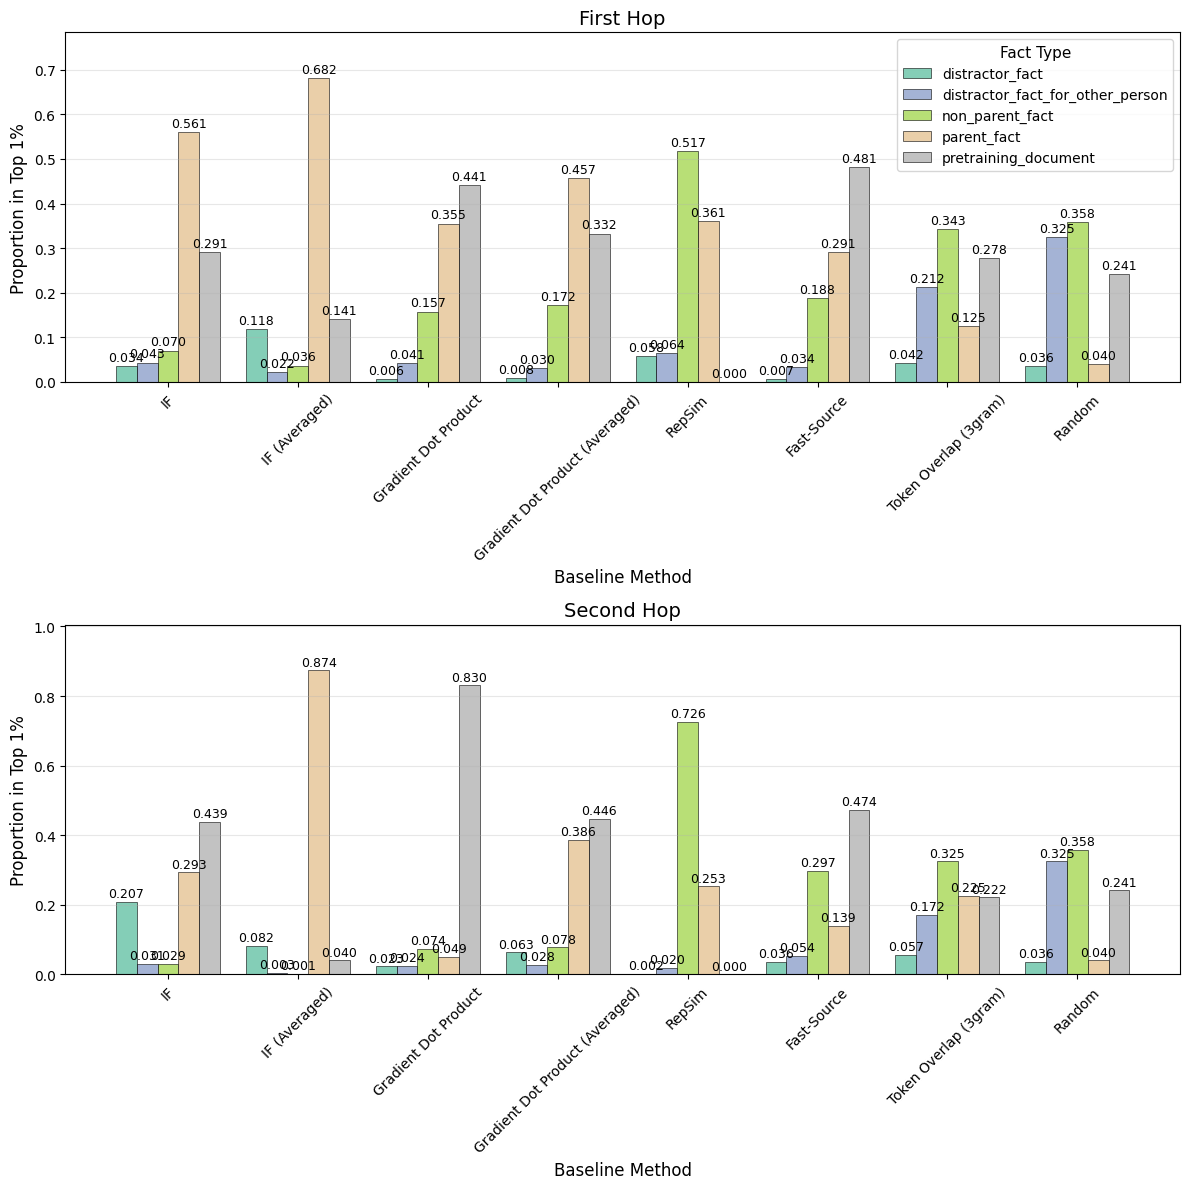

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_vs_baselines.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_vs_baselines.csv

Parent Fact Proportions in Top 1% by Baseline:
                              Name  First-Hop  Second-Hop
0                               IF   0.560811    0.293243
1                    IF (Averaged)   0.681757    0.873649
2             Gradient Dot Product   0.354730    0.049324
3  Gradient Dot Product (Averaged)   0.457432    0.385811
4                           RepSim   0.360714    0.252679
5                      Fast-Source   0.290541    0.139189
6            Token Overlap (3gram)   0.125000    0.225000
7                           Random   0.039779    0.039779
Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 260701.64it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 264888.84it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 255302.66it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263909.87it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263177.19it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 258889.89it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 259791.92it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 258771.24it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 264506.83it/s]


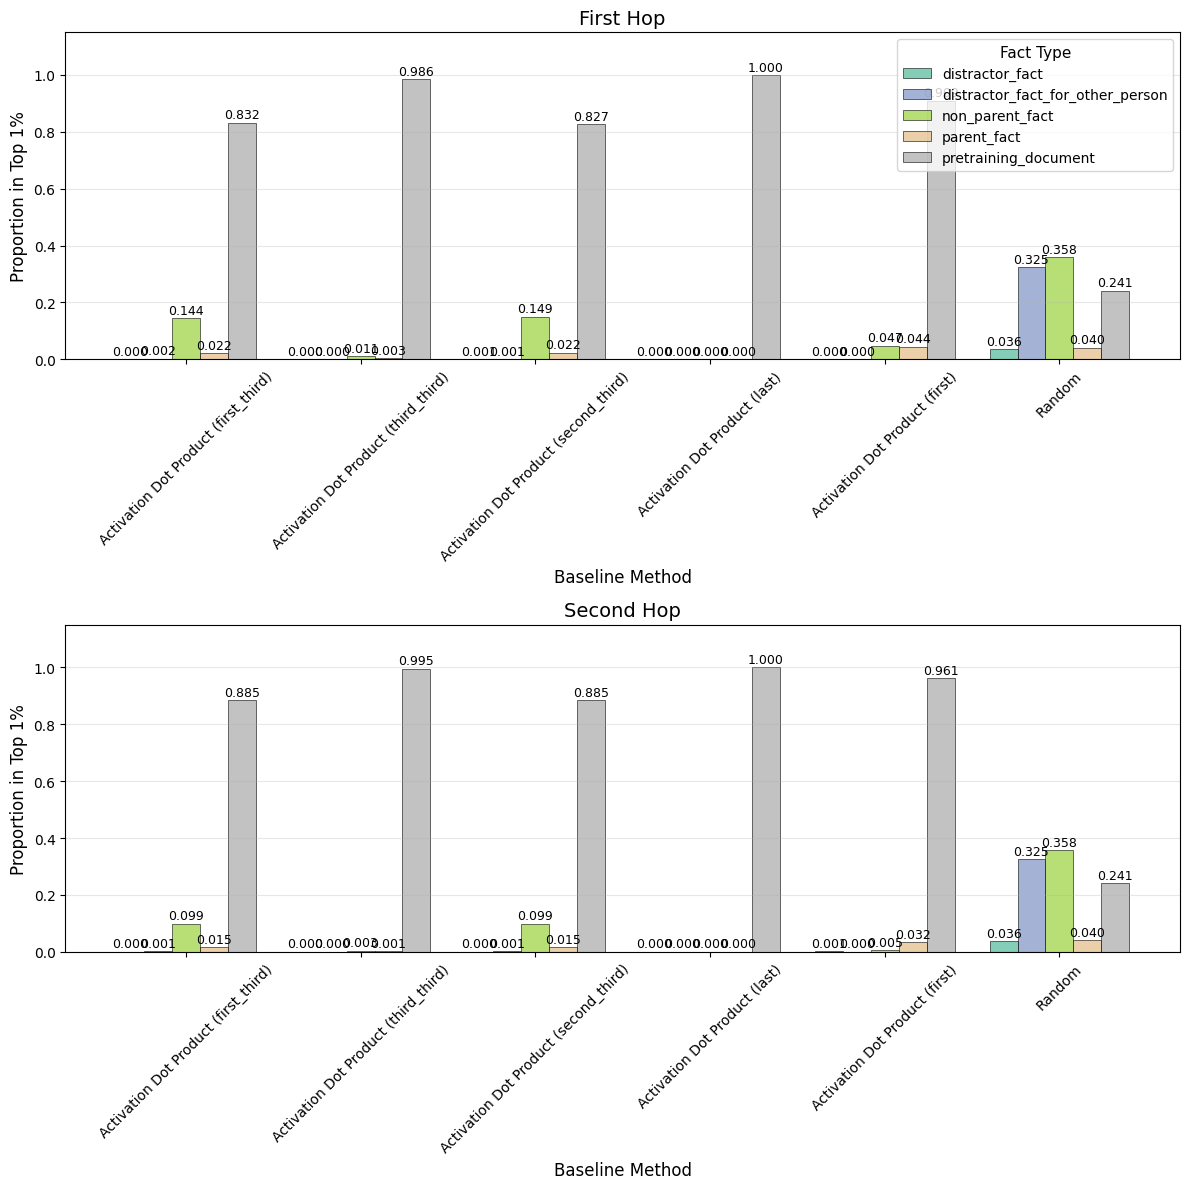

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_vs_baselines.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_vs_baselines.csv

Parent Fact Proportions in Top 1% by Baseline:
                                    Name  First-Hop  Second-Hop
0   Activation Dot Product (first_third)   0.021622    0.014865
1   Activation Dot Product (third_third)   0.002703    0.001351
2  Activation Dot Product (second_third)   0.022297    0.014865
3          Activation Dot Product (last)   0.000000    0.000000
4         Activation Dot Product (first)   0.043919    0.032432
5                                 Random   0.039779    0.039779


{'First Hop': {'Activation Dot Product (first_third)': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.0,
    'distractor_fact_for_other_person': 0.002027027027027027,
    'non_parent_fact': 0.14391891891891892,
    'parent_fact': 0.021621621621621623,
    'pretraining_document': 0.8324324324324325}},
  'Activation Dot Product (third_third)': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.0,
    'distractor_fact_for_other_person': 0.0,
    'non_parent_fact': 0.011486486486486487,
    'par

In [5]:
# Updated baseline definitions with correct run-IDs taken from the table above
baselines = [
    # ──────────────────────────── Influence Functions ────────────────────────────
    BaselineResults(
        baseline_name="IF",
        second_hop_run_id="qg0lw11y",      # ekfac • checkpoint_final • second-hop
        first_hop_run_id="0zuvqxmg",       # ekfac • checkpoint_final • first-hop
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(
        baseline_name="IF (Averaged)",
        second_hop_run_id=add_averaged_run_to_run_dict(
            ["qg0lw11y", "xzfs0p1z", "oakaco0o", "m1cep0d5", "982dznwu", "0580bux2"],
            
        ),
        first_hop_run_id=add_averaged_run_to_run_dict(
            ["0zuvqxmg", "vyooks6g", "8xiit89f", "kncs5csf", "xhily75k", "f5bp0niv"],
        ),
        baseline_type="influence_averaged",
        old_result=True,
    ),

    # ─────────────────────── Gradient-Dot-Product baselines ──────────────────────
    BaselineResults(
        baseline_name="Gradient Dot Product",
        second_hop_run_id="qjz1aieb",      # identity • checkpoint_final • second-hop
        first_hop_run_id="mopgnok3",       # identity • checkpoint_final • first-hop
        old_result=True,
    ),
    BaselineResults(
        baseline_name="Gradient Dot Product (Averaged)",
        second_hop_run_id=add_averaged_run_to_run_dict(
            ["qjz1aieb", "wj5fjlon", "gef1lcjp", "gmcg6bg5", "qiq13om9", "xv5u0u9l"],
      
        ),
        first_hop_run_id=add_averaged_run_to_run_dict(
            ["mopgnok3", "1mo39kha", "ksnff1qb", "7rhtnu22", "lzpmvyf8", "s28lilhe"],
            
        ),
        baseline_type="influence_averaged",
    ),

    # ────────────────────────────── RepSim (unchanged) ───────────────────────────
    BaselineResults(
        baseline_name="RepSim",
        second_hop_run_id="evahb77v",
        first_hop_run_id="a6dq0r9z",
        baseline_type="activation_dot_product",
    ),

    # ──────────────────────────────── Fast-Source ────────────────────────────────
    BaselineResults(
        baseline_name="Fast-Source",
        first_hop_run_id="26u2m98d",       # fast-source • first-hop
        second_hop_run_id="gx6y279p",      # fast-source • second-hop
        baseline_type="influence",
    ),
]

# Register non-averaged runs so their logs are available later
for baseline in baselines:
    if baseline.baseline_type in ["influence", "activation_dot_product"]:
        add_runs_to_run_dict(
            [baseline.first_hop_run_id, baseline.second_hop_run_id],
            run_type=baseline.baseline_type,
            allow_mismatched_keys=baseline.old_result,
        )




# Token-overlap baseline (left untouched)
baselines += [
    BaselineResults(
        baseline_name="Token Overlap (3gram)",
        second_hop_run_id=add_token_overlap_run_to_run_dict("26u2m98d", ngram_length=3, allow_mismatched_keys=True),
        first_hop_run_id=add_token_overlap_run_to_run_dict("gx6y279p", ngram_length=3, allow_mismatched_keys=True),
        baseline_type="token_overlap",
    )
]

# Build plotting dict and render figure
baseline_plotting_dict = {
    baseline.baseline_name: {
        "first_hop_run_id": run_id_to_data[baseline.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[baseline.second_hop_run_id],
    }
    for baseline in baselines
}

plot_baselines(
    baseline_plotting_dict,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_vs_baselines.pdf",
)

# Activation dot product Baselines
baselines_activation_dot_product = [
    BaselineResults(
        baseline_name="Activation Dot Product (first_third)",
        first_hop_run_id="vj4xq78r",
        second_hop_run_id="rtgh03nh",
        baseline_type="activation_dot_product",
    ),
    BaselineResults(
        baseline_name="Activation Dot Product (third_third)",
        first_hop_run_id="40h51y4g",
        second_hop_run_id="f5ztpnrv",
        baseline_type="activation_dot_product",
    ),
    BaselineResults(
        baseline_name="Activation Dot Product (second_third)",
        first_hop_run_id="hyp96jvn",
        second_hop_run_id="rtgh03nh",
        baseline_type="activation_dot_product",
    ),
    BaselineResults(
        baseline_name="Activation Dot Product (last)",
        first_hop_run_id="430kwyhb",
        second_hop_run_id="7eslxmof",
        baseline_type="activation_dot_product",
    ),
    BaselineResults(
        baseline_name="Activation Dot Product (first)",
        first_hop_run_id="6fwoocvo",
        second_hop_run_id="2hb30kla",
        baseline_type="activation_dot_product",
    ),
]

for baseline in baselines_activation_dot_product:
    add_runs_to_run_dict(
        [baseline.first_hop_run_id, baseline.second_hop_run_id],
        run_type=baseline.baseline_type,
        allow_mismatched_keys=baseline.old_result,
    )
# Build plotting dict and render figure
baseline_plotting_dict_dot_product = {
    baseline.baseline_name: {
        "first_hop_run_id": run_id_to_data[baseline.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[baseline.second_hop_run_id],
    }
    for baseline in baselines_activation_dot_product
}

plot_baselines(
    baseline_plotting_dict_dot_product,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_vs_baselines.pdf",
)

In [10]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Fast-Source baselines (learning-rate sweep #2)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source lr=100",
        first_hop_run_id="95c2ivio",
        second_hop_run_id="z9x6b6d2",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 10
        baseline_name="Fast-Source lr=10",
        first_hop_run_id="lb48gypv",
        second_hop_run_id="vxpvxuyv",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source lr=1",
        first_hop_run_id="p5dlgoar",
        second_hop_run_id="ta5fo3ib",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.001
        baseline_name="Fast-Source lr=0.001",
        first_hop_run_id="kgvajwbs",
        second_hop_run_id="q5x6i7bs",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.00001
        baseline_name="Fast-Source lr=0.00001",
        first_hop_run_id="v9ekawu2",
        second_hop_run_id="smechh3s",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 0.000001
        baseline_name="Fast-Source lr=0.000001",
        first_hop_run_id="phr7fros",
        second_hop_run_id="9d63k0mg",
        baseline_type="influence",
        old_result=True,
    ),
]




# ───────────────────────── Register runs so their logs are cached ──────────────
for b in baselines:
    add_runs_to_run_dict(
        [b.first_hop_run_id, b.second_hop_run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# ─────────────────────────── Build plotting dict & render ──────────────────────
baseline_plotting_dict = {
    b.baseline_name: {
        "first_hop_run_id": run_id_to_data[b.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[b.second_hop_run_id],
    }
    for b in baselines
}

plot_baselines(
    baseline_plotting_dict,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_lr_sweep_2.pdf",
)


KeyboardInterrupt: 

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 233945.99it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 233905.22it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 238135.09it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 235773.09it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 240909.41it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 233989.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234843.80it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 236035.10it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234673.07it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 235972.23it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 232232.93it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234742.15it/s]


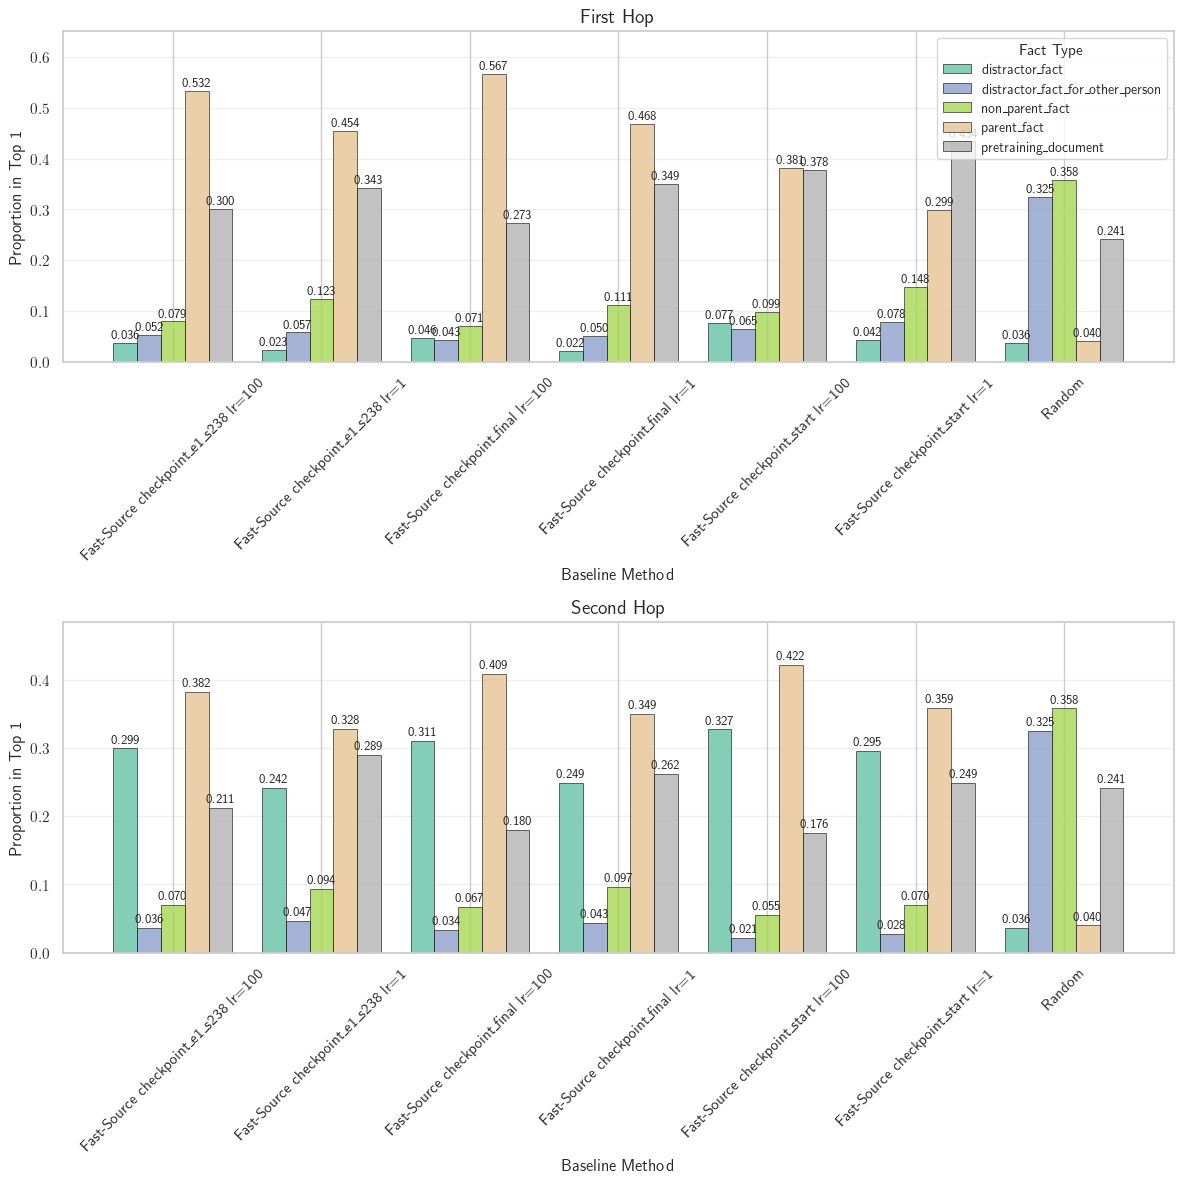

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/fast_source_ckpt_lr_sweep.csv

Parent Fact Proportions in Top 1% by Baseline:
                                    Name  First-Hop  Second-Hop
0  Fast-Source checkpoint_e1_s238 lr=100   0.532432    0.382432
1    Fast-Source checkpoint_e1_s238 lr=1   0.454054    0.328378
2    Fast-Source checkpoint_final lr=100   0.566892    0.408784
3      Fast-Source checkpoint_final lr=1   0.468243    0.349324
4    Fast-Source checkpoint_start lr=100   0.381081    0.421622
5      Fast-Source checkpoint_start lr=1   0.298649    0.358784
6                                 Random   0.039779    0.039779


{'First Hop': {'Fast-Source checkpoint_e1_s238 lr=100': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.03648648648648649,
    'distractor_fact_for_other_person': 0.05202702702702703,
    'non_parent_fact': 0.07905405405405405,
    'parent_fact': 0.5324324324324324,
    'pretraining_document': 0.3}},
  'Fast-Source checkpoint_e1_s238 lr=1': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.022972972972972978,
    'distractor_fact_for_other_person': 0.057432432432432436,
    'non_parent_fact'

In [11]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Fast-Source baselines grouped by (checkpoint, learning-rate)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    # ───────────── checkpoint_e1_s238 ─────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_e1_s238 lr=100",
        first_hop_run_id="cekx0wex",
        second_hop_run_id="6947ggy8",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_e1_s238 lr=1",
        first_hop_run_id="438wnepb",
        second_hop_run_id="kf82lxqv",
        baseline_type="influence",
        old_result=True,
    ),

    # ───────────── checkpoint_final ───────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_final lr=100",
        first_hop_run_id="n2vtgbfr",
        second_hop_run_id="r06g37of",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_final lr=1",
        first_hop_run_id="hotmmn19",
        second_hop_run_id="mmljwxum",
        baseline_type="influence",
        old_result=True,
    ),

    # ───────────── checkpoint_start ───────────────
    BaselineResults(  # lr = 100
        baseline_name="Fast-Source checkpoint_start lr=100",
        first_hop_run_id="y0czh82u",
        second_hop_run_id="paphxtqz",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # lr = 1
        baseline_name="Fast-Source checkpoint_start lr=1",
        first_hop_run_id="guxqcqj4",
        second_hop_run_id="87koln4e",
        baseline_type="influence",
        old_result=True,
    ),
]

# ───────────────────────── Register runs so their logs are cached ──────────────
for b in baselines:
    add_runs_to_run_dict(
        [b.first_hop_run_id, b.second_hop_run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# ─────────────────────────── Build plotting dict & render ──────────────────────
baseline_plotting_dict = {
    b.baseline_name: {
        "first_hop_run_id": run_id_to_data[b.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[b.second_hop_run_id],
    }
    for b in baselines
}

plot_baselines(
    baseline_plotting_dict,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "fast_source_ckpt_lr_sweep.pdf",
)



Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 236554.54it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234894.38it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 233622.74it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 235802.56it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 235719.83it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234687.40it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 232544.83it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 236028.21it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 234029.29it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 233275.79it/s]


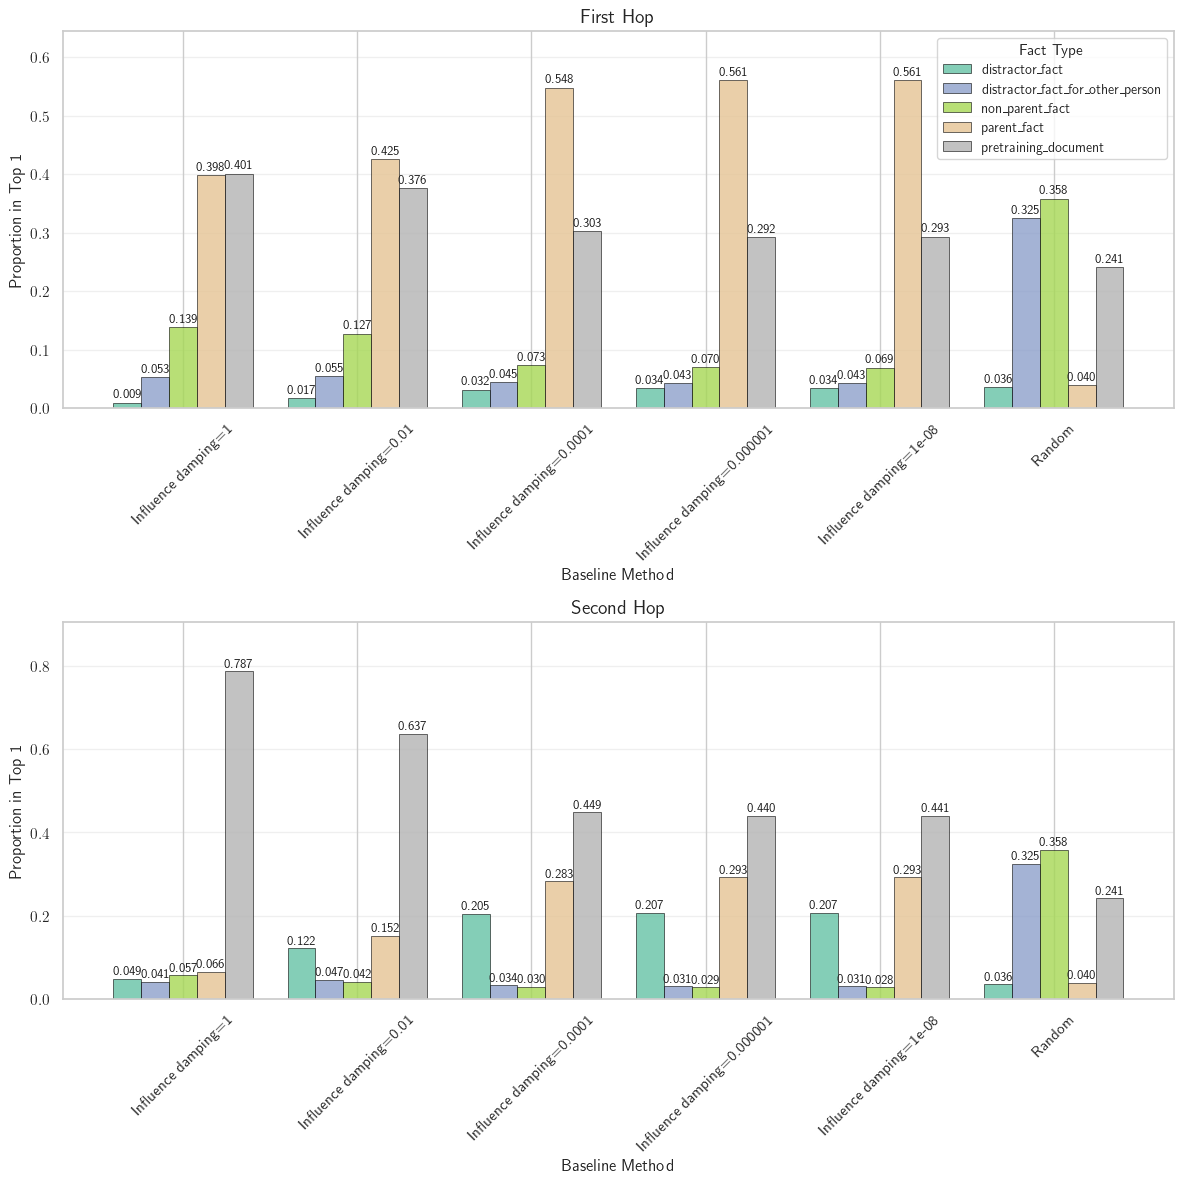

Plot saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep.pdf
Results table saved to: /h/319/max/malign-influence/analysis/final_paper_figures/influence_damping_sweep.csv

Parent Fact Proportions in Top 1% by Baseline:
                         Name  First-Hop  Second-Hop
0         Influence damping=1   0.397973    0.066216
1      Influence damping=0.01   0.425000    0.152027
2    Influence damping=0.0001   0.547973    0.283108
3  Influence damping=0.000001   0.560811    0.292568
4     Influence damping=1e-08   0.560811    0.292568
5                      Random   0.039779    0.039779


{'First Hop': {'Influence damping=1': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.00945945945945946,
    'distractor_fact_for_other_person': 0.05337837837837839,
    'non_parent_fact': 0.13851351351351351,
    'parent_fact': 0.397972972972973,
    'pretraining_document': 0.40067567567567564}},
  'Influence damping=0.01': {'base_rates': {'distractor_fact': 0.03607157381049207,
    'distractor_fact_for_other_person': 0.3246441642944286,
    'non_parent_fact': 0.35801138674257826,
    'parent_fact': 0.03977904297139759,
    'pretraining_document': 0.24149383218110343},
   'percentile_proportions': {'distractor_fact': 0.016891891891891893,
    'distractor_fact_for_other_person': 0.05472972972972974,
    'non_parent_fact': 0.1270270270270

In [12]:
# ────────────────────────────────────────────────────────────────────────────────
#  Hard-coded Influence baselines (damping sweep)
# ────────────────────────────────────────────────────────────────────────────────
baselines = [
    BaselineResults(  # damping = 1
        baseline_name="Influence damping=1",
        first_hop_run_id="s3vfukap",
        second_hop_run_id="9s1xucgo",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.01
        baseline_name="Influence damping=0.01",
        first_hop_run_id="z6n2yflx",
        second_hop_run_id="udiud735",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.0001
        baseline_name="Influence damping=0.0001",
        first_hop_run_id="1lahipy1",
        second_hop_run_id="n0c7mv12",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 0.000001
        baseline_name="Influence damping=0.000001",
        first_hop_run_id="i3akyh0i",
        second_hop_run_id="tbka1sfe",
        baseline_type="influence",
        old_result=True,
    ),
    BaselineResults(  # damping = 1 × 10⁻⁸
        baseline_name="Influence damping=1e-08",
        first_hop_run_id="sma223hz",
        second_hop_run_id="4tcyyu9m",
        baseline_type="influence",
        old_result=True,
    ),
]

# ───────────────────────── Register runs so their logs are cached ──────────────
for b in baselines:
    add_runs_to_run_dict(
        run_ids=[b.first_hop_run_id, b.second_hop_run_id],
        run_dict=run_id_to_data,
        run_type=b.baseline_type,
        allow_mismatched_keys=b.old_result,
    )

# ─────────────────────────── Build plotting dict & render ──────────────────────
baseline_plotting_dict = {
    b.baseline_name: {
        "first_hop_run_id": run_id_to_data[b.first_hop_run_id],
        "second_hop_run_id": run_id_to_data[b.second_hop_run_id],
    }
    for b in baselines
}

plot_baselines(
    baseline_plotting_dict,
    percentile=1,
    save_location=ANALYSIS_SAVE_DIR / "influence_damping_sweep.pdf",
)


## Figure 5: Influence Scores Across Training

These are the same experiments as the section above this one.

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 262151.50it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 272688.46it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 269986.29it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 270336.94it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 271386.46it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 266040.55it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263078.57it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 267085.50it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 256255.36it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 263631.61it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 265816.40it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 262002.27it/s]
/tmp/ipykernel_609690/3821966688.py:173: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(
/tmp/ipykernel_609690/3821966688.py:173: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(


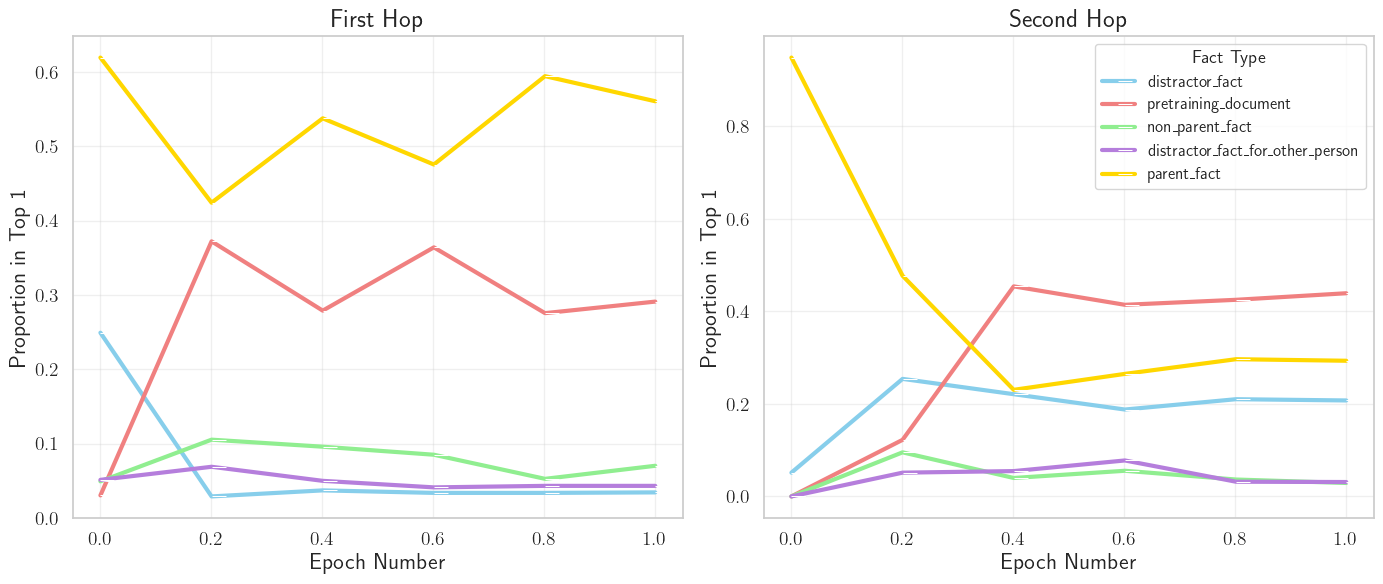

Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 267150.76it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 265838.61it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 267408.54it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 251935.53it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 262593.85it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 267620.51it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 268731.90it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 267477.66it/s]


Building test dataset lookup dictionary...
Building train dataset lookup dictionary...
Processing influence scores...


295080it [00:01, 265235.63it/s]


In [ ]:
from typing import Callable
from oocr_influence.cli.run_influence import InfluenceArgs
from oocr_influence.cli.train_extractive import TrainingArgs

ALL_TYPES = ["pretraining_document", "parent_fact", "non_parent_fact", "few_shot_example", "distractor_fact", "distractor_fact_for_other_person"]

def calculate_proportions_of_types_in_percentiles(
    influence_scores_df: pd.DataFrame,
    percentiles: list[float],  # e.g., [1, 5, 10, 20] for top 1%, 5%, etc.
    types_to_plot: list[str] = ALL_TYPES,
    query_ids_to_focus_on: list[str] | None = None,
    ids_to_keep: list[str] | None = None,
) -> dict:
    """
    Calculate proportions of different types in top percentile documents vs base rates.

    Args:
        influence_scores_df: DataFrame with columns [query_id, train_id, influence_score, datapoint_type]
        percentiles: List of percentiles to analyze (e.g., [1, 5, 10, 20] for top 1%, 5%, etc.)
        types_to_plot: List of type names to include in analysis
        query_ids_to_focus_on: Optional list of query IDs to focus on
        ids_to_keep: Optional list of train IDs to include in analysis
        
    Returns:
        Dictionary with base_rates and percentile_proportions
    """
    import numpy as np
    
    # Filter to specific queries if requested
    if query_ids_to_focus_on is not None:
        influence_scores_df = influence_scores_df[influence_scores_df['query_id'].isin(query_ids_to_focus_on)]
    
    # Filter to specific train IDs if requested
    if ids_to_keep is not None:
        influence_scores_df = influence_scores_df[influence_scores_df['train_id'].isin(ids_to_keep)]
    
    # Get unique query IDs
    unique_queries = sorted(influence_scores_df['query_id'].unique())
    
    def calculate_base_rates(df_subset):
        """Helper function to calculate base rates for a subset of data"""
        base_rates = {}
        type_counts = df_subset['datapoint_type'].value_counts()
        total_pairs = len(df_subset)
        
        for type_name in types_to_plot:
            if type_name in type_counts:
                base_rates[type_name] = type_counts[type_name] / total_pairs
            else:
                base_rates[type_name] = 0.0
        return base_rates
    
    def calculate_percentile_proportions(df_subset, query_ids_list):
        """Helper function to calculate percentile proportions for a subset of data"""
        percentile_to_proportions = {}

        for percentile in percentiles:
            type_proportions = {type_name: [] for type_name in types_to_plot}
            
            # Process each query
            for query_id in query_ids_list:
                # Get all influence scores for this query
                query_df = df_subset[df_subset['query_id'] == query_id]
                n = len(query_df)
                if n == 0:
                    continue
                k = max(1, int(np.ceil(n * percentile / 100.0)))
                # Sort by influence score (descending) and take top k
                top_percentile_df = query_df.nlargest(k, 'influence_score')
                
                # Count types in top percentile
                top_percentile_type_counts = top_percentile_df['datapoint_type'].value_counts()
                
                # Calculate proportions for this query
                for type_name in types_to_plot:
                    if type_name in top_percentile_type_counts:
                        proportion = top_percentile_type_counts[type_name] / len(top_percentile_df)
                    else:
                        proportion = 0.0
                    type_proportions[type_name].append(proportion)
            
            # Average across queries
            avg_proportions = {}
            for type_name in types_to_plot:
                avg_proportions[type_name] = np.mean(type_proportions[type_name]) if type_proportions[type_name] else 0.0
            
            percentile_to_proportions[percentile] = avg_proportions
            
        return percentile_to_proportions
    
    # Calculate base rates (proportion of each type across all query-train pairs)
    base_rates = calculate_base_rates(influence_scores_df)

    # Calculate proportions for each percentile
    percentile_to_proportions = calculate_percentile_proportions(influence_scores_df, unique_queries)

    return {
        'base_rates': base_rates,
        'percentile_proportions': percentile_to_proportions
    }


def plot_checkpoint_vs_top_percentile_facts(
    runs: list,
    checkpoint_name_to_epoch: Callable[[str], int],
    title: str | None = None,
    plot_ratio: bool = False,
    percentile: float = 1,
    ids_to_keep: list[str] | None = None,
    ax = None
) -> None:
    """
    Plot epoch numbers vs proportions of "parent fact" and "atomic fact" in top percentile.
    
    Args:
        runs: List of InfluenceRunData objects
        checkpoint_name_to_epoch: Function that maps checkpoint name to epoch number
        title: Optional title for the plot
        plot_ratio: If True, plot ratio of actual rate to base rate
        percentile: Which percentile to analyze (e.g., 1 for top 1%)
        ids_to_keep: Optional list of train IDs to include in analysis
        ax: Optional matplotlib axes object to plot on
    """
    import seaborn as sns
    
    # Prepare data for seaborn
    data_rows = []
    
    for run_data in runs:
        scores_df, train_dataset, log, train_log = run_data.scores_df, run_data.train_dataset, run_data.if_experiment_log, run_data.training_experiment_log

        types_to_plot = list(set(scores_df["datapoint_type"].unique()))
        assert all(type_name in ALL_TYPES for type_name in types_to_plot)

        # Calculate proportions for this run
        k_to_proportions = calculate_proportions_of_types_in_percentiles(
            influence_scores_df=scores_df, 
            percentiles=[percentile],
            ids_to_keep=ids_to_keep,
            types_to_plot=types_to_plot
        )

        args = InfluenceArgs.model_validate(log.args)
        topk_proportions = k_to_proportions["percentile_proportions"][percentile]
        epoch = checkpoint_name_to_epoch(args.checkpoint_name)
        
        for proportion_name, proportion in topk_proportions.items():
            if plot_ratio:
                base_rate = k_to_proportions["base_rates"][proportion_name]
                if base_rate > 0:
                    proportion = proportion / base_rate
                else:
                    proportion = 0.0 if proportion == 0 else float('inf')
            
            data_rows.append({
                'Epoch': epoch,
                'Fact Type': proportion_name,
                'Proportion': proportion
            })

    
    if not data_rows:
        print("No valid data found for plotting")
        return
    
    # Create DataFrame
    df = pd.DataFrame(data_rows)
    
    # Get train dataset size for labeling (use first run)
    train_dataset_size = len(runs[0].train_dataset) if runs else 0
    
    # Create seaborn lineplot
    sns.lineplot(
        data=df,
        x='Epoch',
        y='Proportion', 
        hue='Fact Type',
        marker=True,
        markersize=10,
        linewidth=3,
        palette=['#87ceeb', '#f08080', '#90ee90', '#b57edc', '#ffd700', '#ffa500', '#ffc0cb', '#98fb98', '#dda0dd', '#f0e68c'],
        ax=ax
    )
    
    # Customize the plot
    ax.set_xlabel('Epoch Number', fontsize=16)
    
    if plot_ratio:
        ax.set_ylabel(f'Ratio (Actual/Base Rate) in Top {percentile}%', fontsize=16)
        # Add horizontal line at y=1 to show where actual rate equals base rate
        ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Equal to base rate')
    else:
        ax.set_ylabel(f'Proportion in Top {percentile}% (n={int(train_dataset_size * percentile / 100)})', fontsize=16)
    
    if title is not None:
        ax.set_title(title, fontsize=18)
    
    # Increase tick label font size
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Add grid
    ax.grid(True, alpha=0.3)


@dataclass
class FirstAndSecondHopDuringTraining:
    first_hop_runs : list [str]
    second_hop_runs: list[str]
    title: str | None = None
    first_hop_title: str = "First Hop"
    second_hop_title: str = "Second Hop"
    save_name : str = "influence_across_training.pdf"
    old_result: bool = False


plots = [FirstAndSecondHopDuringTraining(
    second_hop_runs=["qg0lw11y", "xzfs0p1z", "oakaco0o", "m1cep0d5", "982dznwu", "0580bux2"],
    first_hop_runs=["0zuvqxmg", "vyooks6g", "8xiit89f", "kncs5csf", "xhily75k", "f5bp0niv"],
    first_hop_title="First Hop",
    second_hop_title="Second Hop",
    save_name="influence_across_training.pdf",
    old_result=True

),
FirstAndSecondHopDuringTraining(
    second_hop_runs=["qjz1aieb", "wj5fjlon", "gef1lcjp", "gmcg6bg5", "qiq13om9", "xv5u0u9l"],
    first_hop_runs=["mopgnok3", "1mo39kha", "ksnff1qb", "7rhtnu22", "lzpmvyf8", "s28lilhe"],
    first_hop_title="First Hop",
    second_hop_title="Second Hop",
    save_name="gradoent_dot_product_across_training.pdf",
    old_result=True
)]



def plot_first_and_second_hop_during_training(config: FirstAndSecondHopDuringTraining,run_id_to_data: dict[str, InfluenceRunData]=run_id_to_data) -> None:
    all_run_ids = config.first_hop_runs + config.second_hop_runs
    add_runs_to_run_dict(all_run_ids,run_dict=run_id_to_data, run_type="influence", allow_mismatched_keys=config.old_result)

    # Create figure with two subfigures - made them skinnier
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Plot first hop
    first_hop_runs = [run_id_to_data[run_id] for run_id in config.first_hop_runs]
    assert len(first_hop_runs) > 0
    
    # Get training info from first run to set up epoch conversion
    for run_data in first_hop_runs:
        scores_df, train_dataset, log, train_log = run_data.scores_df, run_data.train_dataset, run_data.if_experiment_log, run_data.training_experiment_log
        args = InfluenceArgs.model_validate(log.args)
        train_args = TrainingArgs.model_validate(train_log.args)
        break

    _, train_dataset, test_datasets, tokenizer, training_experiment_log = load_experiment_checkpoint(experiment_output_dir=args.target_experiment_dir, checkpoint_name="checkpoint_final", load_model=False, load_tokenizer=False) # type: ignore

    assert isinstance(train_args, TrainingArgs) # type: ignore
    assert isinstance(train_dataset, Dataset) # type: ignore
    num_epochs_total = train_args.epochs
    steps_per_epoch = len(train_dataset) // train_args.batch_size

    def checkpoint_name_to_epoch(checkpoint_name: str, num_epochs_total: int, steps_per_epoch: int) -> float:
        if "final" in checkpoint_name:
            return num_epochs_total
        elif "start" in checkpoint_name:
            return 0
        else:
            num_steps = re.search(r"s(\d+)", checkpoint_name).group(1) #type: ignore
            return int(num_steps) / steps_per_epoch

    plot_checkpoint_vs_top_percentile_facts(
        runs=first_hop_runs, 
        checkpoint_name_to_epoch=lambda x: checkpoint_name_to_epoch(x, num_epochs_total=num_epochs_total, steps_per_epoch=steps_per_epoch), 
        title=config.first_hop_title,
        percentile=1,
        plot_ratio=False,
        ids_to_keep=None,
        ax=ax1,
    )

    # Plot second hop
    second_hop_runs = [run_id_to_data[run_id] for run_id in config.second_hop_runs]
    assert len(second_hop_runs) > 0

    plot_checkpoint_vs_top_percentile_facts(
        runs=second_hop_runs, 
        checkpoint_name_to_epoch=lambda x: checkpoint_name_to_epoch(x, num_epochs_total=num_epochs_total, steps_per_epoch=steps_per_epoch), 
        title=config.second_hop_title,
        percentile=1,
        plot_ratio=False,
        ids_to_keep=None,
        ax=ax2,
    )

    # Remove individual legends from subplots
    ax1.get_legend().remove()
    ax2.get_legend().remove()

    # Create unified legend positioned in the top right of the second subplot with larger font
    handles, labels = ax2.get_legend_handles_labels()
    ax2.legend(handles, labels, title='Fact Type', loc='upper right', fontsize=12, title_fontsize=13, framealpha=0.8)

    plt.tight_layout()
    if config.title is not None:
        plt.suptitle(config.title, fontsize=18)
    plt.savefig(ANALYSIS_SAVE_DIR / config.save_name, format="pdf", bbox_inches='tight', transparent=True)
    plt.show()

for plot in plots:  
    plot_first_and_second_hop_during_training(plot)